# The Galerkin Method

The *Galerkin method* is a popular way of solving (partial) differential equations by discretizing them and solving the resulting linear system. Here, we will do so using a probabilistic linear solver. We consider the Dirichlet problem for the Poisson equation given by
$$
\begin{cases}
-\Delta u(x,y) = f(x,y) &(x,y) \in \operatorname{int}\Omega\\
u(x,y) = u_{\partial \Omega}(x,y) &(x,y) \in \partial \Omega
\end{cases}
$$

on a pre-generated mesh.

In [1]:
# Make inline plots vector graphics instead of raster graphics
%matplotlib inline
from IPython.display import set_matplotlib_formats

set_matplotlib_formats("pdf", "svg")

# Plotting
import matplotlib.pyplot as plt

plt.style.use("../../probnum.mplstyle")

## Discretization Mesh

We used [FEniCS](https://fenicsproject.org/) to compute a mesh on a circular domain. The mesh results from a choice of basis functions comprising a discrete subspace of the function space $V$ of solutions $u$.

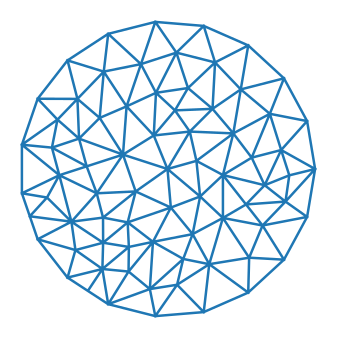

In [2]:
import numpy as np
import matplotlib.tri as tri

# Setup
data_path = "../../data/PDE_discretization/"

# Load mesh data
mesh_resolution_coarse = 6
mesh_resolution_fine = 128
mesh_xy = np.load(file=data_path + "mesh_xy_res{}.npy".format(mesh_resolution_coarse))
mesh_cells = np.load(
    file=data_path + "mesh_cells_res{}.npy".format(mesh_resolution_coarse)
)
triang = tri.Triangulation(mesh_xy[:, 0], mesh_xy[:, 1], mesh_cells)

# Plot mesh
fig, axes = plt.subplots(nrows=1, ncols=1, squeeze=False)
axes[0, 0].triplot(triang, linewidth=2.5, color="C2")
axes[0, 0].axis("scaled")
axes[0, 0].axis("off")
fig.tight_layout(pad=0, w_pad=0, h_pad=0)
plt.show()

## Problem in Matrix Form

The choice of basis functions which induced the mesh lead to a discretization of the Dirichlet problem. This discretization can be represented as a linear system $A \mathbf{u} = \mathbf{f}$.

In [3]:
import scipy.sparse

# Load linear system from file
A = scipy.sparse.load_npz(
    file=data_path + "matrix_poisson_res{}.npz".format(mesh_resolution_coarse)
)
f = np.load(file=data_path + "rhs_poisson_res{}.npy".format(mesh_resolution_coarse))

print(np.linalg.cond(A.todense()))
print("Problem dimension: {}".format(A.shape[0]))

24.789619046465486
Problem dimension: 74


The resulting matrix is sparse. The diagonal in the upper left arises from the boundary conditions.

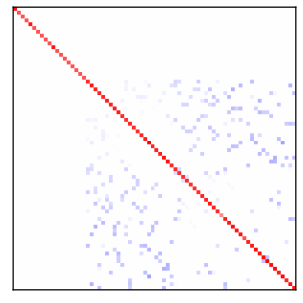

In [4]:
# Plot discretized differential operator
vmax = np.max(np.abs(A.todense()))
vmin = -vmax

fig, axes = plt.subplots(nrows=1, ncols=1, squeeze=False)
axes[0, 0].imshow(A.todense(), cmap="bwr", vmin=vmin, vmax=vmax)
axes[0, 0].set_xticks([])
axes[0, 0].set_yticks([])
plt.tight_layout()

## Solution using a Probabilistic Linear Solver

We will now solve this problem using a probabilistic linear solver. This allows us to quantify numerical uncertainty and to incorporate prior knowledge about the solution.

In [5]:
from probnum.linalg import problinsolve

# Solve linear system
uhat, Ahat, Ainvhat, info = problinsolve(A, f)
print(info)

# Save solution to file
np.save(data_path + f"solution_res{mesh_resolution_coarse}.npy", uhat.mean)

{'iter': 21, 'maxiter': 740, 'resid_l2norm': 4.0951695730536484e-05, 'trace_sol_cov': 20.197255365797368, 'conv_crit': 'resid_rtol', 'rel_cond': None}


### Estimated Solution

We plot the estimated solution of the solver and some samples from the posterior distribution over the solution. 

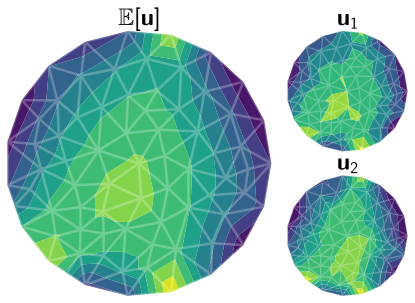

In [6]:
# Load mesh data
mesh_xy = np.load(file=data_path + "mesh_xy_res{}.npy".format(mesh_resolution_coarse))
mesh_cells = np.load(
    file=data_path + "mesh_cells_res{}.npy".format(mesh_resolution_coarse)
)

# Interpolation levels and color scaling
interpol_levels = None
vmin_tricont = np.min(uhat.mean.ravel())
vmax_tricont = np.max(uhat.mean.ravel())

# Sample from Posterior
np.random.seed(42)
n_samples = 2
usamples = uhat.sample(n_samples)

soldict = {"$\\bm{\\mathsf{u}}_1$": usamples[0], "$\\bm{\\mathsf{u}}_2$": usamples[1]}

# Figure with gridspecs
fig = plt.figure(figsize=(5.8, 4), constrained_layout=False)
gs0 = fig.add_gridspec(1, 2, width_ratios=[2, 1])
gs00 = gs0[0].subgridspec(1, 1, wspace=0)
gs01 = gs0[1].subgridspec(2, 1, wspace=0)

# Estimated solution
fig.add_subplot(gs00[0, 0])
plt.tricontourf(
    triang,
    uhat.mean.ravel(),
    levels=interpol_levels,
    vmin=vmin_tricont,
    vmax=vmax_tricont,
)
plt.triplot(triang, linewidth=2.5, color="white", alpha=0.25)
plt.title("$\mathbb{E}[\\bm{\\mathsf{u}}]$", fontsize=24)
plt.axis("scaled")
plt.axis("off")

# Samples
for i, (title, uvec) in enumerate(soldict.items()):
    fig.add_subplot(gs01[i, 0])
    plt.tricontourf(
        triang, uvec, levels=interpol_levels, vmin=vmin_tricont, vmax=vmax_tricont
    )
    plt.triplot(triang, linewidth=1.25, color="white", alpha=0.25)
    plt.title(title, fontsize=24, y=1)
    plt.axis("scaled")
    plt.axis("off")

fig.tight_layout(pad=0, w_pad=0, h_pad=0)

### Estimated Linear Operators

We can also inspect the estimate of the discretized differential operator itself and its inverse.

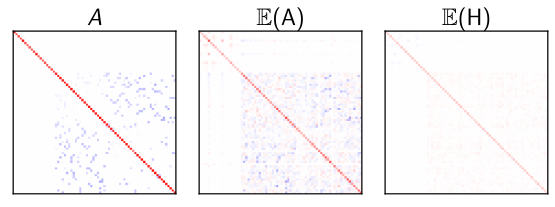

In [7]:
# Plot linear operators
matdict = {
    "$A$": A.todense(),
    "$\mathbb{E}(\mathsf{A})$": Ahat.mean.todense(),
    "$\mathbb{E}(\mathsf{H})$": Ainvhat.mean.todense(),
}

# Set imshow limits uniform across matrices
vmax = np.max([np.max(np.abs(mat)) for mat in list(matdict.values())])
vmin = -vmax

fig, axes = plt.subplots(
    nrows=1, ncols=len(matdict), figsize=(8, 4), squeeze=False, sharex=True, sharey=True
)
for i, (title, mat) in enumerate(matdict.items()):
    # Plot matrix
    axes[0, i].imshow(mat, cmap="bwr", vmin=vmin, vmax=vmax)
    axes[0, i].set_title(title, fontsize=24)
    axes[0, i].set_xticks([])
    axes[0, i].set_yticks([])
plt.tight_layout()

## Error and Uncertainty Calibration

To see how well our computed solution approximates the "true" solution, we solved the same problem on a much finer mesh and interpolated to the coarse mesh. This allows us to compute errors and check the calibration of the uncertainty returned by the probabilistic linear solver.

In [8]:
# Load (interpolated) solution from file
u = np.load(file=data_path + "solution_res{}.npy".format(mesh_resolution_coarse))
u_interpol = np.load(
    file=data_path
    + "solution_interpol_res{}tores{}.npy".format(
        mesh_resolution_fine, mesh_resolution_coarse
    )
)

We compute the signed relative error $\lVert u \rVert^{-1}(u - \mathbb{E}[\mathsf{u}])$ and the scaled error $(\Sigma^+)^{-\frac{1}{2}}(u - \mathbb{E}[\mathsf{u}])$, where $\Sigma$ is the covariance matrix of $\mathsf{u}$.

In [9]:
# Compute error
error_u = u_interpol - u
rel_error_u = error_u / np.linalg.norm(u)

# Scaled error
Sigma = uhat.cov.todense()
Sigma_pseudoinv = np.linalg.pinv(Sigma, hermitian=True)
scaled_error_u = np.real_if_close(
    scipy.linalg.sqrtm(Sigma_pseudoinv) @ error_u, tol=10 ** 8
)

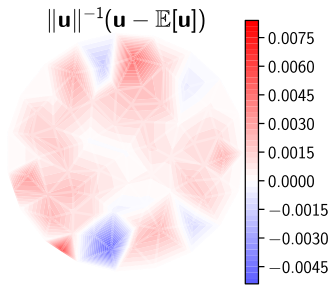

In [10]:
# Colormap scale
vmax = np.max(np.abs(rel_error_u))
vmin = -vmax

# Plot
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(4.5, 4), squeeze=False)
triang = tri.Triangulation(mesh_xy[:, 0], mesh_xy[:, 1], mesh_cells)
tricon = plt.tricontourf(
    triang, rel_error_u, levels=50, cmap="bwr", vmin=vmin, vmax=vmax
)
cbar = plt.colorbar(tricon, pad=0)
cbar.ax.tick_params(labelsize=18)
plt.triplot(triang, linewidth=2.5, color="white", alpha=0.25)
plt.title(
    "$\\lVert \\bm{u} \\rVert^{-1} (\\bm{u} - \mathbb{E}[\\bm{\\mathsf{u}}])$",
    fontsize=24,
)
plt.axis("scaled")
plt.axis("off")
fig.tight_layout(pad=0, w_pad=0, h_pad=0)

If the uncertainty of the probabilistic linear solver is well calibrated, then the scaled error $(\Sigma^+)^{-\frac{1}{2}}(u - \mathbb{E}[\mathsf{u}])$ is a sample of a standard normal distribution.

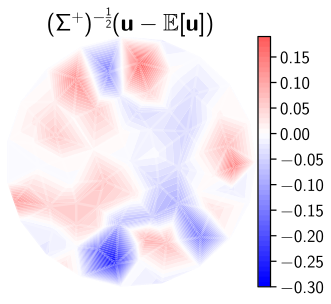

In [11]:
# Colormap scale
vmax = np.max(np.abs(scaled_error_u))
vmin = -vmax

# Plot scaled error
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(4.5, 4), squeeze=False)
triang = tri.Triangulation(mesh_xy[:, 0], mesh_xy[:, 1], mesh_cells)
tricon = plt.tricontourf(
    triang, scaled_error_u, levels=50, cmap="bwr", vmin=vmin, vmax=vmax
)
cbar = plt.colorbar(tricon, pad=0)
cbar.ax.tick_params(labelsize=18)
plt.triplot(triang, linewidth=2.5, color="white", alpha=0.25)
plt.title(
    "$(\\Sigma^{+})^{-\\frac{1}{2}} ( \\bm{u} - \mathbb{E}[\\bm{\\mathsf{u}}] )$",
    fontsize=24,
)
plt.axis("scaled")
plt.axis("off")
fig.tight_layout(pad=0, w_pad=0, h_pad=0)